In [48]:
# Standard libraries
import os
import math

# Data manipulation and analysis
import numpy as np
import pandas as pd

#Data Visualization
import matplotlib.pyplot as plt

# datetime index
from datetime import datetime,date,timedelta

# Machine Learning - Scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, ParameterGrid, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  MinMaxScaler, StandardScaler

# Satistical analysis- SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product # generates the Cartesian product of all input iterable parameters


import warnings
warnings.filterwarnings('ignore')


In [50]:
# Readin the data set kepping date as index
df=pd.read_csv('weighted_sum.csv')

# Make the 'date' column as index of the DataFrame
df.index = df["date"].values

df.index = pd.to_datetime(df.index)

df.drop(columns='date', inplace=True)

# Reindexing DataFrame with pd.date_range, ensure df spans a specified period, filling in any gaps with NaN values.
idx = pd.date_range('2019-10-24', '2023-12-06')

df = df.reindex(idx)
print(df.shape)

# filter out the specified data range contaning zero
df=df.drop(df.loc['2023-05-12':'2023-07-27'].index)

# Filter out the initial date range considering machine unstability
df=df.drop(df.loc['2019-10-24':'2020-01-31'].index)


rows_to_fill = np.where(df["weighted_sum"].isna())

for row in rows_to_fill:

    df.iloc[row] = df.iloc[row + 7]

# Replace negative values with zero in 'weighted_sum'
df['weighted_sum'] = df['weighted_sum'].clip(lower=0)

# replace 7 irregular data points with 8th highest value.
df[df['weighted_sum']>570]=570

print(df)
df.describe()

(1505, 1)
            weighted_sum
2020-02-01    239.210369
2020-02-02     28.280318
2020-02-03    199.366981
2020-02-04    423.067131
2020-02-05    409.692107
...                  ...
2023-12-02    114.049422
2023-12-03      0.000000
2023-12-04    226.893157
2023-12-05    390.659238
2023-12-06    425.322937

[1328 rows x 1 columns]


,weighted_sum
count,1328.000000
mean,294.511578
std,164.458734
min,0.000000
25%,149.168497
50%,356.291042
75%,428.762568
max,570.000000


### 1.2 Normalize data can helps in faster convergence and better generalization 

ARIMA/SARIMA models do not require any scaling of the data. In contrast, any dataset used for a machine learning model typically needs to be scaled. SARIMA specifically expects data with a predefined seasonal frequency, meaning the number of periods per season. It does not account for dates themselves. For our dataset, we have a vector of observations with a frequency of 7, which could represent daily data with weekly seasonality. However, normalization is irrelevant to SARIMA; it only focuses on the frequency.

https://stats.stackexchange.com/questions/608658/arima-or-sarima-scale-and-normalize-data

## Train Test Split

In [52]:
# Define the train-test split parameters (70:30)
initial_train_size = int(0.7 * len(df)) # Start with 70% training data
initial_train_data= df[:initial_train_size]
initial_test_data=df[initial_train_size:]


# Now, split the initial training data into 70% training and 30% validation
train_size = int(0.7 * len(initial_train_data))
train_data=initial_train_data[:train_size]
test_data = initial_train_data[train_size:]
print(initial_train_data, initial_test_data , train_data ,test_data)

            weighted_sum
2020-02-01    239.210369
2020-02-02     28.280318
2020-02-03    199.366981
2020-02-04    423.067131
2020-02-05    409.692107
...                  ...
2022-08-13    114.743957
2022-08-14      0.000000
2022-08-15    273.145554
2022-08-16    382.488038
2022-08-17    276.267078

[929 rows x 1 columns]             weighted_sum
2022-08-18    193.901423
2022-08-19    432.053452
2022-08-20    134.239967
2022-08-21      0.000000
2022-08-22    293.099946
...                  ...
2023-12-02    114.049422
2023-12-03      0.000000
2023-12-04    226.893157
2023-12-05    390.659238
2023-12-06    425.322937

[399 rows x 1 columns]             weighted_sum
2020-02-01    239.210369
2020-02-02     28.280318
2020-02-03    199.366981
2020-02-04    423.067131
2020-02-05    409.692107
...                  ...
2021-11-07      0.000000
2021-11-08    128.806820
2021-11-09    416.624904
2021-11-10    436.489289
2021-11-11    444.859699

[650 rows x 1 columns]             weighted_sum
202

###  Grid Search SARIMA Hyperparameters
Selection of seasonal and non-seasonal components of the model in terms of lower RMSE value.


In [79]:
def sarima_grid_search(train_data, test_data, p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    best_score, best_cfg = float("inf"), None
    list_scores = []
    
    # Generate all combinations of p, d, q, P, D, Q, and seasonal period (s)
    for p, d, q, P, D, Q, s in product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
        order = (p, d, q)
        seasonal_order = (P, D, Q, s)
        try:
            # Define and fit the SARIMA model
            model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            
            # Make in-sample predictions (for training data)
            predictions_train = model_fit.predict(start=0, end=len(train_data) - 1)
            
            # Make out-of-sample predictions (for testing data)
            predictions_test = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
            
            # Calculate the root mean squared error (RMSE) for test predictions
            rmse = sqrt(mean_squared_error(test_data, predictions_test))
            
            # Save the best model configuration based on RMSE
            if rmse < best_score:
                best_score, best_cfg = rmse, (order, seasonal_order)
            
            print(f"SARIMAX{order}x{seasonal_order} - RMSE: {rmse:.3f}")
            list_scores.append((rmse, order, seasonal_order))
        
        except Exception as e:
            print(f"SARIMA{order}x{seasonal_order} - Error: {e}")
            continue
    
    # Sort the list of RMSE scores and corresponding configurations in ascending order
    list_scores_sorted = sorted(list_scores)
    
    if best_cfg:
        print(f"\nBest SARIMA{best_cfg[0]}x{best_cfg[1]} - RMSE: {best_score:.3f}")
    else:
        print("\nNo valid SARIMA configuration found.")
    
    return best_cfg, predictions_test, list_scores_sorted


# Define the range of parameters for the grid search
p_values = range(0, 1)
d_values = range(0, 2)
q_values = range(0, 1)
P_values = range(0, 1)
D_values = range(0, 2)
Q_values = range(0, 1)
s_values = [7]  # Seasonal period 

# Perform the grid search
best_cfg, predictions, list_scores_sorted = sarima_grid_search(train_data, test_data, p_values, d_values, q_values, P_values, D_values, Q_values, s_values)


SARIMAX(0, 0, 0)x(0, 0, 0, 7) - RMSE: 344.216
SARIMAX(0, 0, 0)x(0, 1, 0, 7) - RMSE: 107.800
SARIMAX(0, 1, 0)x(0, 0, 0, 7) - RMSE: 220.180
SARIMAX(0, 1, 0)x(0, 1, 0, 7) - RMSE: 3867.178

Best SARIMA(0, 0, 0)x(0, 1, 0, 7) - RMSE: 107.800


In [81]:
def sarima_grid_search(train_data, test_data, p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    best_score, best_cfg = float("inf"), None
    list_scores = []
    
    # Generate all combinations of p, d, q, P, D, Q, and seasonal period (s)
    for p, d, q, P, D, Q, s in product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
        order = (p, d, q)
        seasonal_order = (P, D, Q, s)
        try:
            # Define and fit the SARIMA model
            model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            
            # Make in-sample predictions (for training data)
            predictions_train = model_fit.predict(start=0, end=len(train_data) - 1)
            
            # Make out-of-sample predictions (for testing data)
            predictions_test = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
            
            # Calculate the root mean squared error (RMSE) for test predictions
            rmse = sqrt(mean_squared_error(test_data, predictions_test))
            
            # Save the best model configuration based on RMSE
            if rmse < best_score:
                best_score, best_cfg = rmse, (order, seasonal_order)
            
            print(f"SARIMAX{order}x{seasonal_order} - RMSE: {rmse:.3f}")
            list_scores.append((rmse, order, seasonal_order))
        
        except Exception as e:
            print(f"SARIMA{order}x{seasonal_order} - Error: {e}")
            continue
    
    # Sort the list of RMSE scores and corresponding configurations in ascending order
    list_scores_sorted = sorted(list_scores)
    
    if best_cfg:
        print(f"\nBest SARIMA{best_cfg[0]}x{best_cfg[1]} - RMSE: {best_score:.3f}")
    else:
        print("\nNo valid SARIMA configuration found.")
    
    return best_cfg, predictions_test, list_scores_sorted


# Define the range of parameters for the grid search
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
s_values = [7]  # Seasonal period
# Perform the grid search
best_cfg, predictions, list_scores_sorted = sarima_grid_search(train_data, test_data, p_values, d_values, q_values, P_values, D_values, Q_values, s_values)

# Print the sorted RMSE scores with corresponding model configurations
print("\nSorted RMSE values with corresponding model configurations:")

for score, order, seasonal_order in list_scores_sorted:
    print(f"RMSE: {score:.3f} - SARIMA{order}x{seasonal_order}")

SARIMAX(0, 0, 0)x(0, 0, 0, 7) - RMSE: 344.216
SARIMAX(0, 0, 0)x(0, 0, 1, 7) - RMSE: 341.093
SARIMAX(0, 0, 0)x(0, 1, 0, 7) - RMSE: 107.800
SARIMAX(0, 0, 0)x(0, 1, 1, 7) - RMSE: 86.852
SARIMAX(0, 0, 0)x(1, 0, 0, 7) - RMSE: 230.894
SARIMAX(0, 0, 0)x(1, 0, 1, 7) - RMSE: 87.921
SARIMAX(0, 0, 0)x(1, 1, 0, 7) - RMSE: 128.851
SARIMAX(0, 0, 0)x(1, 1, 1, 7) - RMSE: 82.537
SARIMAX(0, 0, 1)x(0, 0, 0, 7) - RMSE: 343.520
SARIMAX(0, 0, 1)x(0, 0, 1, 7) - RMSE: 339.908
SARIMAX(0, 0, 1)x(0, 1, 0, 7) - RMSE: 106.571
SARIMAX(0, 0, 1)x(0, 1, 1, 7) - RMSE: 85.476
SARIMAX(0, 0, 1)x(1, 0, 0, 7) - RMSE: 258.844
SARIMAX(0, 0, 1)x(1, 0, 1, 7) - RMSE: 86.628
SARIMAX(0, 0, 1)x(1, 1, 0, 7) - RMSE: 129.157
SARIMAX(0, 0, 1)x(1, 1, 1, 7) - RMSE: 83.211
SARIMAX(0, 1, 0)x(0, 0, 0, 7) - RMSE: 220.180
SARIMAX(0, 1, 0)x(0, 0, 1, 7) - RMSE: 332.431
SARIMAX(0, 1, 0)x(0, 1, 0, 7) - RMSE: 3867.178
SARIMAX(0, 1, 0)x(0, 1, 1, 7) - RMSE: 148.694
SARIMAX(0, 1, 0)x(1, 0, 0, 7) - RMSE: 660.792
SARIMAX(0, 1, 0)x(1, 0, 1, 7) - RMSE: 1

In [66]:
def sarima_grid_search(train_data, test_data, p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    best_score, best_cfg = float("inf"), None
    list_scores = []
    
    # Generate all combinations of p, d, q, P, D, Q, and seasonal period (s)
    for p, d, q, P, D, Q, s in product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
        order = (p, d, q)
        seasonal_order = (P, D, Q, s)
        try:
            # Define and fit the SARIMA model
            model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            
            # Make in-sample predictions (for training data)
            predictions_train = model_fit.predict(start=0, end=len(train_data) - 1)
            
            # Make out-of-sample predictions (for testing data)
            predictions_test = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
            
            # Calculate the root mean squared error (RMSE) for test predictions
            rmse = sqrt(mean_squared_error(test_data, predictions_test))
            
            # Save the best model configuration based on RMSE
            if rmse < best_score:
                best_score, best_cfg = rmse, (order, seasonal_order)
            
            print(f"SARIMAX{order}x{seasonal_order} - RMSE: {rmse:.3f}")
            list_scores.append((rmse, order, seasonal_order))
        
        except Exception as e:
            print(f"SARIMA{order}x{seasonal_order} - Error: {e}")
            continue
    
    # Sort the list of RMSE scores and corresponding configurations in ascending order
    list_scores_sorted = sorted(list_scores)
    
    if best_cfg:
        print(f"\nBest SARIMA{best_cfg[0]}x{best_cfg[1]} - RMSE: {best_score:.3f}")
    else:
        print("\nNo valid SARIMA configuration found.")
    
    return best_cfg, predictions_test, list_scores_sorted


p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
s_values = [7]
# Perform the grid search
best_cfg, predictions, list_scores_sorted = sarima_grid_search(train_data, test_data, p_values, d_values, q_values, P_values, D_values, Q_values, s_values)



SARIMAX(0, 0, 0)x(0, 0, 0, 7) - RMSE: 344.216
SARIMAX(0, 0, 0)x(0, 0, 1, 7) - RMSE: 341.093
SARIMAX(0, 0, 0)x(0, 0, 2, 7) - RMSE: 337.993
SARIMAX(0, 0, 0)x(0, 1, 0, 7) - RMSE: 107.800
SARIMAX(0, 0, 0)x(0, 1, 1, 7) - RMSE: 86.852
SARIMAX(0, 0, 0)x(0, 1, 2, 7) - RMSE: 82.797
SARIMAX(0, 0, 0)x(1, 0, 0, 7) - RMSE: 230.894
SARIMAX(0, 0, 0)x(1, 0, 1, 7) - RMSE: 87.921
SARIMAX(0, 0, 0)x(1, 0, 2, 7) - RMSE: 83.171
SARIMAX(0, 0, 0)x(1, 1, 0, 7) - RMSE: 128.851
SARIMAX(0, 0, 0)x(1, 1, 1, 7) - RMSE: 82.537
SARIMAX(0, 0, 0)x(1, 1, 2, 7) - RMSE: 83.451
SARIMAX(0, 0, 0)x(2, 0, 0, 7) - RMSE: 182.889
SARIMAX(0, 0, 0)x(2, 0, 1, 7) - RMSE: 82.803
SARIMAX(0, 0, 0)x(2, 0, 2, 7) - RMSE: 82.965
SARIMAX(0, 0, 0)x(2, 1, 0, 7) - RMSE: 118.891
SARIMAX(0, 0, 0)x(2, 1, 1, 7) - RMSE: 82.531
SARIMAX(0, 0, 0)x(2, 1, 2, 7) - RMSE: 82.537
SARIMAX(0, 0, 1)x(0, 0, 0, 7) - RMSE: 343.520
SARIMAX(0, 0, 1)x(0, 0, 1, 7) - RMSE: 339.908
SARIMAX(0, 0, 1)x(0, 0, 2, 7) - RMSE: 337.712
SARIMAX(0, 0, 1)x(0, 1, 0, 7) - RMSE: 106.57

In [73]:
def sarima_grid_search(train_data, test_data, p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    best_score, best_cfg = float("inf"), None
    list_scores = []
    
    # Generate all combinations of p, d, q, P, D, Q, and seasonal period (s)
    for p, d, q, P, D, Q, s in product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
        order = (p, d, q)
        seasonal_order = (P, D, Q, s)
        try:
            # Define and fit the SARIMA model
            model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            
            # Make in-sample predictions (for training data)
            predictions_train = model_fit.predict(start=0, end=len(train_data) - 1)
            
            # Make out-of-sample predictions (for testing data)
            predictions_test = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
            
            # Calculate the root mean squared error (RMSE) for test predictions
            rmse = sqrt(mean_squared_error(test_data, predictions_test))
            
            # Save the best model configuration based on RMSE
            if rmse < best_score:
                best_score, best_cfg = rmse, (order, seasonal_order)
            
            print(f"SARIMAX{order}x{seasonal_order} - RMSE: {rmse:.3f}")
            list_scores.append((rmse, order, seasonal_order))
        
        except Exception as e:
            print(f"SARIMA{order}x{seasonal_order} - Error: {e}")
            continue
    
    # Sort the list of RMSE scores and corresponding configurations in ascending order
    list_scores_sorted = sorted(list_scores)
    
    if best_cfg:
        print(f"\nBest SARIMA{best_cfg[0]}x{best_cfg[1]} - RMSE: {best_score:.3f}")
    else:
        print("\nNo valid SARIMA configuration found.")
    
    return best_cfg, predictions_test, list_scores_sorted


# Define the range of parameters for the grid search
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)
P_values = range(0, 4)
D_values = range(0, 2)
Q_values = range(0, 4)
s_values = [7]
# Perform the grid search
best_cfg, predictions, list_scores_sorted = sarima_grid_search(train_data, test_data, p_values, d_values, q_values, P_values, D_values, Q_values, s_values)

# Print the sorted RMSE scores with corresponding model configurations
print("\nSorted RMSE values with corresponding model configurations:")

for score, order, seasonal_order in list_scores_sorted:
    print(f"RMSE: {score:.3f} - SARIMA{order}x{seasonal_order}")

SARIMAX(0, 0, 0)x(0, 0, 0, 7) - RMSE: 344.216
SARIMAX(0, 0, 0)x(0, 0, 1, 7) - RMSE: 341.093
SARIMAX(0, 0, 0)x(0, 0, 2, 7) - RMSE: 337.993
SARIMAX(0, 0, 0)x(0, 0, 3, 7) - RMSE: 336.405
SARIMAX(0, 0, 0)x(0, 1, 0, 7) - RMSE: 107.800
SARIMAX(0, 0, 0)x(0, 1, 1, 7) - RMSE: 86.852
SARIMAX(0, 0, 0)x(0, 1, 2, 7) - RMSE: 82.797
SARIMAX(0, 0, 0)x(0, 1, 3, 7) - RMSE: 82.688
SARIMAX(0, 0, 0)x(1, 0, 0, 7) - RMSE: 230.894
SARIMAX(0, 0, 0)x(1, 0, 1, 7) - RMSE: 87.921
SARIMAX(0, 0, 0)x(1, 0, 2, 7) - RMSE: 83.171
SARIMAX(0, 0, 0)x(1, 0, 3, 7) - RMSE: 83.065
SARIMAX(0, 0, 0)x(1, 1, 0, 7) - RMSE: 128.851
SARIMAX(0, 0, 0)x(1, 1, 1, 7) - RMSE: 82.537
SARIMAX(0, 0, 0)x(1, 1, 2, 7) - RMSE: 83.451
SARIMAX(0, 0, 0)x(1, 1, 3, 7) - RMSE: 82.743
SARIMAX(0, 0, 0)x(2, 0, 0, 7) - RMSE: 182.889
SARIMAX(0, 0, 0)x(2, 0, 1, 7) - RMSE: 82.803
SARIMAX(0, 0, 0)x(2, 0, 2, 7) - RMSE: 82.965
SARIMAX(0, 0, 0)x(2, 0, 3, 7) - RMSE: 83.255
SARIMAX(0, 0, 0)x(2, 1, 0, 7) - RMSE: 118.891
SARIMAX(0, 0, 0)x(2, 1, 1, 7) - RMSE: 82.531
S

In [77]:
# from tabulate import tabulate
from tabulate import tabulate
from docx import Document

# Create a new Word document
doc = Document()

# Add a heading or title
doc.add_heading('SARIMA Model Comparison', 0)

# Data for the table with empty rows for spacing 
data = [
    ["SARIMA_model_1", "(p, q/P, Q=[0, 1], d/D=[0, 2])", "SARIMA[(0, 0, 0)x(0, 1, 0, 7)]", "Test RMSE: 107.800"],
    ["", "", "", "", ""], 
    ["SARIMA_model_2", "(p, q/P, Q=[0, 2], d/D=[0, 2])", "SARIMA[(1, 1, 1)x(1, 0, 1, 7)]", "Test RMSE: 82.413"],
    ["", "", "", "", ""],  
    ["SARIMA_model_3", "(p, q/P, Q=[0, 3], d/D=[0, 2])", "SARIMA[(2, 1, 1)x(1, 0, 2, 7)]", "Test RMSE: 82.266"],
    ["", "", "", "", ""],  
    ["SARIMA_model_4", "(p, q/P, Q=[0, 4], d/D=[0, 2])", "SARIMA[(0, 0, 0)x(3, 1, 1, 7)]", "Test RMSE: 82.043"],
    ["", "", "", "", ""],  
    #["SARIMA_model_5", "(p, q/P, Q=[0, 5], d/D=[0, 1])", "SARIMA[(4, 1, 2)x(4, 0, 4, 7)]", "Train RMSE: 86.773", "Test RMSE: 119.570"]
]
 
headers = ["Model", "Parameter_range=[p,d,q]x[P,D,Q,s]", "best_cfg", "Testing error"]
# Save the document
doc.save('SARIMA_model_comparison.docx')


# Create and print table
print(tabulate(data, headers, tablefmt="pretty"))


+----------------+-----------------------------------+--------------------------------+--------------------+
|     Model      | Parameter_range=[p,d,q]x[P,D,Q,s] |            best_cfg            |   Testing error    |
+----------------+-----------------------------------+--------------------------------+--------------------+
| SARIMA_model_1 |  (p, q/P, Q=[0, 1], d/D=[0, 2])   | SARIMA[(0, 0, 0)x(0, 1, 0, 7)] | Test RMSE: 107.800 |
|                |                                   |                                |                    |
| SARIMA_model_2 |  (p, q/P, Q=[0, 2], d/D=[0, 2])   | SARIMA[(1, 1, 1)x(1, 0, 1, 7)] | Test RMSE: 82.413  |
|                |                                   |                                |                    |
| SARIMA_model_3 |  (p, q/P, Q=[0, 3], d/D=[0, 2])   | SARIMA[(2, 1, 1)x(1, 0, 2, 7)] | Test RMSE: 82.266  |
|                |                                   |                                |                    |
| SARIMA_model_4 | 

### Seasonal ARIMA with auto.arima function 

In [19]:
from pmdarima import auto_arima
# Fit the auto_arima model
sarima_model = auto_arima(train_data['weighted_sum'], 
                          seasonal=True,            # Enforce seasonality
                          m=7,                     # Season length (monthly data, adjust for your data)
                          stepwise=True,            # Perform stepwise search
                          suppress_warnings=True,   # Ignore convergence warnings
                          trace=True,               # Print progress
                          error_action='ignore',    # Ignore if an order does not work
                          max_order=None,           # No limit on the max order (p,d,q)
                          start_p=1, start_q=1, max_p=10, max_q=10,
                          start_P=1, start_Q=1, max_P=10, max_Q=10,
                          d=None, D=None,           # Let auto_arima decide differencing
                          test='adf')               # Use the Augmented Dickey-Fuller test for stationarity)               

# Print a summary of the best SARIMA model found
print(sarima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=7784.874, Time=1.30 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=8374.620, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=7704.165, Time=1.03 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=7965.004, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=9345.789, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=8290.803, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=7623.824, Time=1.53 sec
 ARIMA(1,0,0)(3,0,0)[7] intercept   : AIC=7588.760, Time=3.16 sec
 ARIMA(1,0,0)(4,0,0)[7] intercept   : AIC=inf, Time=5.81 sec
 ARIMA(1,0,0)(3,0,1)[7] intercept   : AIC=inf, Time=4.30 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(1,0,0)(4,0,1)[7] intercept   : AIC=inf, Time=7.31 sec
 ARIMA(0,0,0)(3,0,0)[7] intercept   : AIC=7718.681, Time=3.53 sec
 ARIMA(2,0,0)(3,0,0)[7] intercept   : AIC=7955.887, Time=4.58 sec
 ARIMA(1,0,1)(3,0,0)[7] intercept   : AIC=inf, Time=3

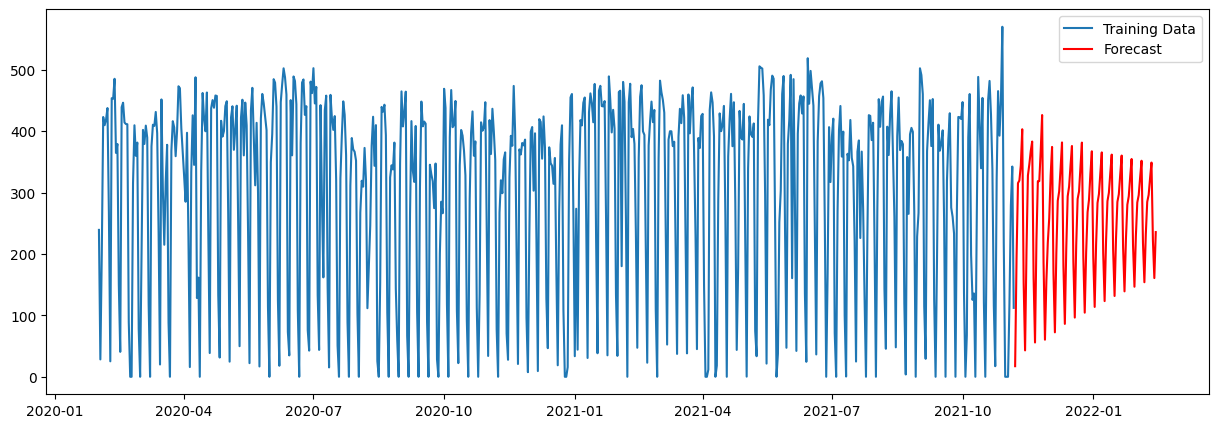

Root Mean Squared Error on training data: 84.83347539492547


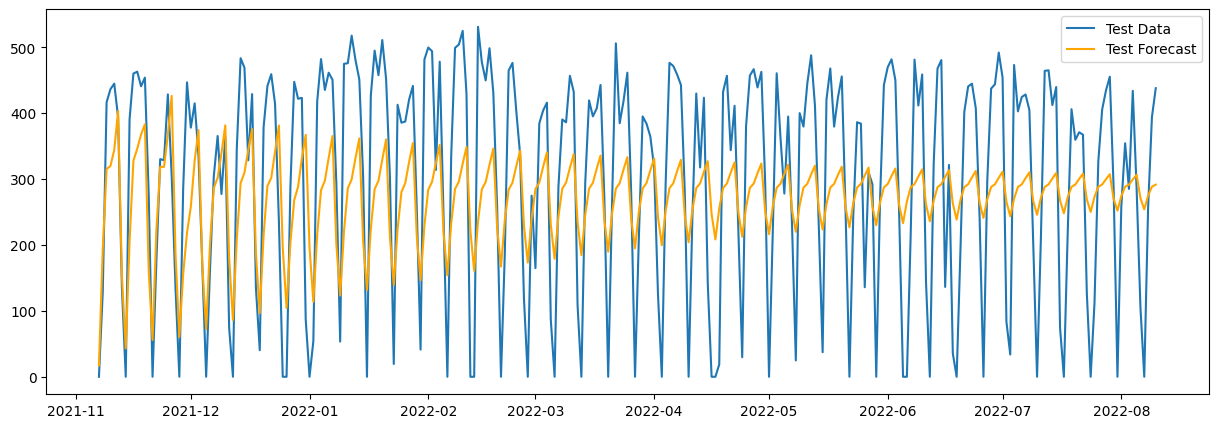

Root Mean Squared Error on test data: 137.9339403167386


In [25]:
# In-sample predictions (on training data)
train_data['SARIMA_Predictions'] = sarima_model.predict_in_sample()

# Forecast future values (next 7 periods in this example)
n_steps = 100
forecast_train = sarima_model.predict(n_periods=n_steps)

# Create a date range for the forecast based on the training data index
train_forecast_index = pd.date_range(start=train_data.index[-1], periods=n_steps+1, freq='D')[1:]

# Plot original data and the forecast
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['weighted_sum'], label='Training Data')
plt.plot(train_forecast_index, forecast_train, label='Forecast', color='red')
plt.legend()
plt.show()

# Calculate MSE on training data
mse = mean_squared_error(train_data['weighted_sum'], train_data['SARIMA_Predictions'])
rmse_train = np.sqrt(mse)
print(f'Root Mean Squared Error on training data: {rmse_train}')



# Forecast for the test set
forecast_test = sarima_model.predict(n_periods=len(test_data))

# Create date range for test forecast
test_forecast_index = pd.date_range(start=train_data.index[-1], periods=len(test_data)+1, freq='D')[1:]

# Plot the test set against the forecast
plt.figure(figsize=(15,5))
plt.plot(test_data.index, test_data['weighted_sum'], label='Test Data')
plt.plot(test_forecast_index, forecast_test, label='Test Forecast', color='orange')
plt.legend()
plt.show()

# Calculate MSE on the test set
mse_test = mean_squared_error(test_data['weighted_sum'], forecast_test)
rmse_test = np.sqrt(mse_test)
print(f'Root Mean Squared Error on test data: {rmse_test}')

